In [19]:
from prophet import Prophet
import itertools
from prophet.diagnostics import cross_validation, performance_metrics
import plotly.offline as py
import matplotlib as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import holidays
from sklearn.metrics import r2_score

In [27]:
training_upto = 2018
forecast_upto = (2023-training_upto-1)*12 

In [28]:
# Read data, get dataframe with crimes/month
monthly_grouped_df = pd.read_csv('C:/Users/20212397/Desktop/Y2Q4/DC2/filtered_df_utility_cols.csv')
monthly_grouped_df= monthly_grouped_df.sort_values(['Year','Month num'],ascending=False).groupby(['Year', 'Month num'])['Burglary Rate'].sum()
monthly_grouped_df = monthly_grouped_df.to_frame()


# Rename columns, select rows with data and set datetime index
monthly_grouped_df = monthly_grouped_df.rename(columns = {'Month num':'y'})
monthly_grouped_df['day'] = 1
monthly_grouped_df = monthly_grouped_df.reset_index()
# monthly_grouped_df = monthly_grouped_df[(monthly_grouped_df['Year']>=2011) | ((monthly_grouped_df['Year'] == 2010) & (monthly_grouped_df['Month num']==12))]
monthly_grouped_df = monthly_grouped_df.rename(columns={'Month num': 'month', 'Year': 'year'})
print(monthly_grouped_df)
monthly_grouped_df['ds'] = pd.to_datetime(monthly_grouped_df[['year', 'month', 'day']])
monthly_grouped_df['y'] = monthly_grouped_df['Burglary Rate']
# monthly_grouped_df = monthly_grouped_df.set_index(pd.DatetimeIndex(monthly_grouped_df['Date']))

# Getting Holidays
holiday = pd.DataFrame([])
for date, name in sorted(holidays.country_holidays('GB', subdiv='England', years=[2012, 2013, 2014, 2015, 2016, 2017, 2018,2019,2020,2021, 2022, 2023, 2024]).items()):
    #holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "England-Holidays"}, index=[0]), ignore_index=True)
    holiday= pd.concat([holiday, pd.DataFrame({'ds': date, 'holiday': "England-Holidays"}, index=[0])], ignore_index=True)

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

# Divide test and train data
train_data = monthly_grouped_df[monthly_grouped_df['year']<(training_upto+1)]
test_data = monthly_grouped_df[(monthly_grouped_df['year']>training_upto)]

monthly_grouped_df


     year  month  Burglary Rate  day
0    2010     12            240    1
1    2011      1            329    1
2    2011      2            272    1
3    2011      3            292    1
4    2011      9            189    1
..    ...    ...            ...  ...
135  2022      8             99    1
136  2022      9            104    1
137  2022     10            143    1
138  2022     11            154    1
139  2022     12            129    1

[140 rows x 4 columns]


,year,month,Burglary Rate,day,ds,y
0,2010,12,240,1,2010-12-01,240
1,2011,1,329,1,2011-01-01,329
2,2011,2,272,1,2011-02-01,272
3,2011,3,292,1,2011-03-01,292
4,2011,9,189,1,2011-09-01,189
...,...,...,...,...,...,...
135,2022,8,99,1,2022-08-01,99
136,2022,9,104,1,2022-09-01,104
137,2022,10,143,1,2022-10-01,143
138,2022,11,154,1,2022-11-01,154


In [22]:
param_grid = { 
    'seasonality_mode':('multiplicative','additive'), 
    'changepoint_prior_scale': [0.05, 0.01, 0.15],
    'seasonality_prior_scale': [0.05, 0.01, 0.15],
    'holidays_prior_scale':[0.005,0.01,0.015],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  # Store the RMSEs for each params here

cutoffs = pd.date_range(start='2015-01-01', end='2021-12-01', freq='2MS')

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params, holidays= holiday).fit(monthly_grouped_df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
print("Mean absolute error: ", np.argmin(maes))
best_params = all_params[np.argmin(maes)]
print("Best parameters", best_params)

15:26:57 - cmdstanpy - INFO - Chain [1] start processing
15:26:57 - cmdstanpy - INFO - Chain [1] done processing
15:27:03 - cmdstanpy - INFO - Chain [1] start processing
15:27:04 - cmdstanpy - INFO - Chain [1] done processing


KeyboardInterrupt: 

15:28:14 - cmdstanpy - INFO - Chain [1] start processing
15:28:14 - cmdstanpy - INFO - Chain [1] done processing


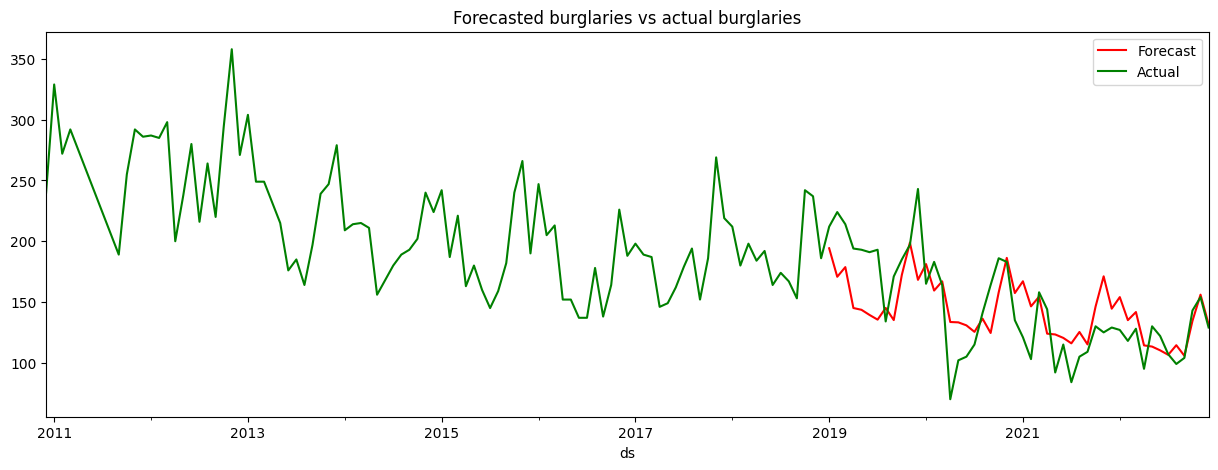

0.44627271206870966

In [29]:
# Train the model with the best parameters and forecast

best_model = Prophet(seasonality_mode= 'multiplicative', changepoint_prior_scale= 0.01, seasonality_prior_scale= 0.15, holidays_prior_scale= 0.015, holidays= holiday).fit(train_data)
future_dates = best_model.make_future_dataframe(periods=forecast_upto, freq='MS')
forecast = best_model.predict(future_dates)

# Plot predictions
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
forecast[-forecast_upto:].plot(kind='line',x='ds', y='yhat', color='red', label='Forecast', ax=ax)
monthly_grouped_df.plot(kind='line',x='ds',y='y', color='green',label='Actual', ax=ax)
plt.title('Forecasted burglaries vs actual burglaries')
plt.show()

r2_score(test_data['y'], forecast['yhat'][-forecast_upto:])


In [47]:
df_per_ward =  pd.read_csv('C:/Users/20212397/Desktop/Y2Q4/DC2/filtered_df_utility_cols.csv')

df_per_ward['Ward'].unique()
df_per_ward['y'] = df_per_ward['Burglary Rate']
df_per_ward['day'] = 1
df_per_ward = df_per_ward.reset_index()
df_per_ward = df_per_ward.rename(columns={'Month num': 'month', 'Year': 'year'})
print(df_per_ward.columns)
df_per_ward['ds'] = pd.to_datetime(df_per_ward[['year', 'month', 'day']])   
train_data_per_ward = df_per_ward[df_per_ward['year']<(training_upto+1)]
test_data_per_ward = df_per_ward[(df_per_ward['year']>training_upto)]


Index(['index', 'Date', 'Ward', 'year', 'Reported by', 'Falls within',
       'Crime type', 'Month name', 'month', 'Burglary Rate', 'Codes',
       'Borough', 'Population', 'Hectares', 'Square Kilometres',
       'Population per hectare', 'Population per square kilometre',
       'Census population (2011)', 'Police Workforce', 'LAD code',
       'Mean Income (£)', 'Median Income (£)', 'y', 'day'],
      dtype='object')


In [50]:
wards = ['Brunswick Park', 'Burnt Oak', 'Childs Hill', 'East Barnet',
       'East Finchley', 'Edgware', 'Finchley Church End', 'Garden Suburb',
       'Golders Green', 'Hendon', 'High Barnet', 'Mill Hill', 'Underhill',
       'West Finchley', 'West Hendon', 'Woodhouse']

for ward in wards: 
       print(train_data_per_ward[train_data_per_ward['Ward']==ward])
       best_model = Prophet(seasonality_mode= 'multiplicative', changepoint_prior_scale= 0.01, seasonality_prior_scale= 0.15, holidays_prior_scale= 0.015, holidays= holiday).fit(train_data_per_ward[train_data_per_ward['Ward']==ward])
       future_dates = best_model.make_future_dataframe(periods=forecast_upto, freq='MS')
       forecast = best_model.predict(future_dates)
       print(r2_score(test_data['y'], forecast['yhat'][-forecast_upto:]))
       

15:47:16 - cmdstanpy - INFO - Chain [1] start processing


      index     Date            Ward  year                  Reported by  \
0         0  2010-12  Brunswick Park  2010  Metropolitan Police Service   
16       16  2011-01  Brunswick Park  2011  Metropolitan Police Service   
17       17  2011-02  Brunswick Park  2011  Metropolitan Police Service   
18       18  2011-03  Brunswick Park  2011  Metropolitan Police Service   
19       19  2011-09  Brunswick Park  2011  Metropolitan Police Service   
...     ...      ...             ...   ...                          ...   
1287   1287  2018-08  Brunswick Park  2018  Metropolitan Police Service   
1288   1288  2018-09  Brunswick Park  2018  Metropolitan Police Service   
1289   1289  2018-10  Brunswick Park  2018  Metropolitan Police Service   
1290   1290  2018-11  Brunswick Park  2018  Metropolitan Police Service   
1291   1291  2018-12  Brunswick Park  2018  Metropolitan Police Service   

                     Falls within Crime type Month name  month  Burglary Rate  \
0     Metropolitan

15:47:16 - cmdstanpy - INFO - Chain [1] done processing
15:47:16 - cmdstanpy - INFO - Chain [1] start processing


-11.25639024722748
      index     Date       Ward  year                  Reported by  \
1         1  2010-12  Burnt Oak  2010  Metropolitan Police Service   
23       23  2011-01  Burnt Oak  2011  Metropolitan Police Service   
24       24  2011-02  Burnt Oak  2011  Metropolitan Police Service   
25       25  2011-03  Burnt Oak  2011  Metropolitan Police Service   
26       26  2011-09  Burnt Oak  2011  Metropolitan Police Service   
...     ...      ...        ...   ...                          ...   
1299   1299  2018-08  Burnt Oak  2018  Metropolitan Police Service   
1300   1300  2018-09  Burnt Oak  2018  Metropolitan Police Service   
1301   1301  2018-10  Burnt Oak  2018  Metropolitan Police Service   
1302   1302  2018-11  Burnt Oak  2018  Metropolitan Police Service   
1303   1303  2018-12  Burnt Oak  2018  Metropolitan Police Service   

                     Falls within Crime type Month name  month  Burglary Rate  \
1     Metropolitan Police Service   Burglary        Dec    

15:47:16 - cmdstanpy - INFO - Chain [1] done processing
15:47:16 - cmdstanpy - INFO - Chain [1] start processing


-11.33153447451683
      index     Date         Ward  year                  Reported by  \
2         2  2010-12  Childs Hill  2010  Metropolitan Police Service   
30       30  2011-01  Childs Hill  2011  Metropolitan Police Service   
31       31  2011-02  Childs Hill  2011  Metropolitan Police Service   
32       32  2011-03  Childs Hill  2011  Metropolitan Police Service   
33       33  2011-09  Childs Hill  2011  Metropolitan Police Service   
...     ...      ...          ...   ...                          ...   
1311   1311  2018-08  Childs Hill  2018  Metropolitan Police Service   
1312   1312  2018-09  Childs Hill  2018  Metropolitan Police Service   
1313   1313  2018-10  Childs Hill  2018  Metropolitan Police Service   
1314   1314  2018-11  Childs Hill  2018  Metropolitan Police Service   
1315   1315  2018-12  Childs Hill  2018  Metropolitan Police Service   

                     Falls within Crime type Month name  month  Burglary Rate  \
2     Metropolitan Police Service  

15:47:17 - cmdstanpy - INFO - Chain [1] done processing
15:47:17 - cmdstanpy - INFO - Chain [1] start processing


-10.240707065168266
      index     Date         Ward  year                  Reported by  \
3         3  2010-12  East Barnet  2010  Metropolitan Police Service   
37       37  2011-01  East Barnet  2011  Metropolitan Police Service   
38       38  2011-02  East Barnet  2011  Metropolitan Police Service   
39       39  2011-03  East Barnet  2011  Metropolitan Police Service   
40       40  2011-09  East Barnet  2011  Metropolitan Police Service   
...     ...      ...          ...   ...                          ...   
1323   1323  2018-08  East Barnet  2018  Metropolitan Police Service   
1324   1324  2018-09  East Barnet  2018  Metropolitan Police Service   
1325   1325  2018-10  East Barnet  2018  Metropolitan Police Service   
1326   1326  2018-11  East Barnet  2018  Metropolitan Police Service   
1327   1327  2018-12  East Barnet  2018  Metropolitan Police Service   

                     Falls within Crime type Month name  month  Burglary Rate  \
3     Metropolitan Police Service 

15:47:17 - cmdstanpy - INFO - Chain [1] done processing
15:47:17 - cmdstanpy - INFO - Chain [1] start processing


-11.627345605296378
      index     Date           Ward  year                  Reported by  \
4         4  2010-12  East Finchley  2010  Metropolitan Police Service   
44       44  2011-01  East Finchley  2011  Metropolitan Police Service   
45       45  2011-02  East Finchley  2011  Metropolitan Police Service   
46       46  2011-03  East Finchley  2011  Metropolitan Police Service   
47       47  2011-09  East Finchley  2011  Metropolitan Police Service   
...     ...      ...            ...   ...                          ...   
1335   1335  2018-08  East Finchley  2018  Metropolitan Police Service   
1336   1336  2018-09  East Finchley  2018  Metropolitan Police Service   
1337   1337  2018-10  East Finchley  2018  Metropolitan Police Service   
1338   1338  2018-11  East Finchley  2018  Metropolitan Police Service   
1339   1339  2018-12  East Finchley  2018  Metropolitan Police Service   

                     Falls within Crime type Month name  month  Burglary Rate  \
4     Metr

15:47:17 - cmdstanpy - INFO - Chain [1] done processing
15:47:18 - cmdstanpy - INFO - Chain [1] start processing


-11.48516230079621
      index     Date     Ward  year                  Reported by  \
5         5  2010-12  Edgware  2010  Metropolitan Police Service   
51       51  2011-01  Edgware  2011  Metropolitan Police Service   
52       52  2011-02  Edgware  2011  Metropolitan Police Service   
53       53  2011-03  Edgware  2011  Metropolitan Police Service   
54       54  2011-09  Edgware  2011  Metropolitan Police Service   
...     ...      ...      ...   ...                          ...   
1347   1347  2018-08  Edgware  2018  Metropolitan Police Service   
1348   1348  2018-09  Edgware  2018  Metropolitan Police Service   
1349   1349  2018-10  Edgware  2018  Metropolitan Police Service   
1350   1350  2018-11  Edgware  2018  Metropolitan Police Service   
1351   1351  2018-12  Edgware  2018  Metropolitan Police Service   

                     Falls within Crime type Month name  month  Burglary Rate  \
5     Metropolitan Police Service   Burglary        Dec     12             17   
51

15:47:18 - cmdstanpy - INFO - Chain [1] done processing
15:47:18 - cmdstanpy - INFO - Chain [1] start processing


-11.244791721146614
      index     Date                 Ward  year                  Reported by  \
6         6  2010-12  Finchley Church End  2010  Metropolitan Police Service   
58       58  2011-01  Finchley Church End  2011  Metropolitan Police Service   
59       59  2011-02  Finchley Church End  2011  Metropolitan Police Service   
60       60  2011-03  Finchley Church End  2011  Metropolitan Police Service   
61       61  2011-09  Finchley Church End  2011  Metropolitan Police Service   
...     ...      ...                  ...   ...                          ...   
1359   1359  2018-08  Finchley Church End  2018  Metropolitan Police Service   
1360   1360  2018-09  Finchley Church End  2018  Metropolitan Police Service   
1361   1361  2018-10  Finchley Church End  2018  Metropolitan Police Service   
1362   1362  2018-11  Finchley Church End  2018  Metropolitan Police Service   
1363   1363  2018-12  Finchley Church End  2018  Metropolitan Police Service   

                   

15:47:18 - cmdstanpy - INFO - Chain [1] done processing
15:47:19 - cmdstanpy - INFO - Chain [1] start processing


-11.652820669523978
      index     Date           Ward  year                  Reported by  \
7         7  2010-12  Garden Suburb  2010  Metropolitan Police Service   
65       65  2011-01  Garden Suburb  2011  Metropolitan Police Service   
66       66  2011-02  Garden Suburb  2011  Metropolitan Police Service   
67       67  2011-03  Garden Suburb  2011  Metropolitan Police Service   
68       68  2011-09  Garden Suburb  2011  Metropolitan Police Service   
...     ...      ...            ...   ...                          ...   
1371   1371  2018-08  Garden Suburb  2018  Metropolitan Police Service   
1372   1372  2018-09  Garden Suburb  2018  Metropolitan Police Service   
1373   1373  2018-10  Garden Suburb  2018  Metropolitan Police Service   
1374   1374  2018-11  Garden Suburb  2018  Metropolitan Police Service   
1375   1375  2018-12  Garden Suburb  2018  Metropolitan Police Service   

                     Falls within Crime type Month name  month  Burglary Rate  \
7     Metr

15:47:19 - cmdstanpy - INFO - Chain [1] done processing
15:47:19 - cmdstanpy - INFO - Chain [1] start processing


-11.498345337377577
      index     Date           Ward  year                  Reported by  \
8         8  2010-12  Golders Green  2010  Metropolitan Police Service   
72       72  2011-01  Golders Green  2011  Metropolitan Police Service   
73       73  2011-02  Golders Green  2011  Metropolitan Police Service   
74       74  2011-03  Golders Green  2011  Metropolitan Police Service   
75       75  2011-09  Golders Green  2011  Metropolitan Police Service   
...     ...      ...            ...   ...                          ...   
1383   1383  2018-08  Golders Green  2018  Metropolitan Police Service   
1384   1384  2018-09  Golders Green  2018  Metropolitan Police Service   
1385   1385  2018-10  Golders Green  2018  Metropolitan Police Service   
1386   1386  2018-11  Golders Green  2018  Metropolitan Police Service   
1387   1387  2018-12  Golders Green  2018  Metropolitan Police Service   

                     Falls within Crime type Month name  month  Burglary Rate  \
8     Metr

15:47:19 - cmdstanpy - INFO - Chain [1] done processing
15:47:19 - cmdstanpy - INFO - Chain [1] start processing


-10.73407923065984
      index     Date    Ward  year                  Reported by  \
9         9  2010-12  Hendon  2010  Metropolitan Police Service   
79       79  2011-01  Hendon  2011  Metropolitan Police Service   
80       80  2011-02  Hendon  2011  Metropolitan Police Service   
81       81  2011-03  Hendon  2011  Metropolitan Police Service   
82       82  2011-09  Hendon  2011  Metropolitan Police Service   
...     ...      ...     ...   ...                          ...   
1395   1395  2018-08  Hendon  2018  Metropolitan Police Service   
1396   1396  2018-09  Hendon  2018  Metropolitan Police Service   
1397   1397  2018-10  Hendon  2018  Metropolitan Police Service   
1398   1398  2018-11  Hendon  2018  Metropolitan Police Service   
1399   1399  2018-12  Hendon  2018  Metropolitan Police Service   

                     Falls within Crime type Month name  month  Burglary Rate  \
9     Metropolitan Police Service   Burglary        Dec     12             13   
79    Metropol

15:47:20 - cmdstanpy - INFO - Chain [1] done processing
15:47:20 - cmdstanpy - INFO - Chain [1] start processing


-11.0796947616939
      index     Date         Ward  year                  Reported by  \
10       10  2010-12  High Barnet  2010  Metropolitan Police Service   
86       86  2011-01  High Barnet  2011  Metropolitan Police Service   
87       87  2011-02  High Barnet  2011  Metropolitan Police Service   
88       88  2011-03  High Barnet  2011  Metropolitan Police Service   
89       89  2011-09  High Barnet  2011  Metropolitan Police Service   
...     ...      ...          ...   ...                          ...   
1407   1407  2018-08  High Barnet  2018  Metropolitan Police Service   
1408   1408  2018-09  High Barnet  2018  Metropolitan Police Service   
1409   1409  2018-10  High Barnet  2018  Metropolitan Police Service   
1410   1410  2018-11  High Barnet  2018  Metropolitan Police Service   
1411   1411  2018-12  High Barnet  2018  Metropolitan Police Service   

                     Falls within Crime type Month name  month  Burglary Rate  \
10    Metropolitan Police Service   

15:47:20 - cmdstanpy - INFO - Chain [1] done processing
15:47:20 - cmdstanpy - INFO - Chain [1] start processing


-9.884280764263496
      index     Date       Ward  year                  Reported by  \
11       11  2010-12  Mill Hill  2010  Metropolitan Police Service   
93       93  2011-01  Mill Hill  2011  Metropolitan Police Service   
94       94  2011-02  Mill Hill  2011  Metropolitan Police Service   
95       95  2011-03  Mill Hill  2011  Metropolitan Police Service   
96       96  2011-09  Mill Hill  2011  Metropolitan Police Service   
...     ...      ...        ...   ...                          ...   
1419   1419  2018-08  Mill Hill  2018  Metropolitan Police Service   
1420   1420  2018-09  Mill Hill  2018  Metropolitan Police Service   
1421   1421  2018-10  Mill Hill  2018  Metropolitan Police Service   
1422   1422  2018-11  Mill Hill  2018  Metropolitan Police Service   
1423   1423  2018-12  Mill Hill  2018  Metropolitan Police Service   

                     Falls within Crime type Month name  month  Burglary Rate  \
11    Metropolitan Police Service   Burglary        Dec    

15:47:20 - cmdstanpy - INFO - Chain [1] done processing
15:47:21 - cmdstanpy - INFO - Chain [1] start processing


-11.676370705330354
      index     Date       Ward  year                  Reported by  \
12       12  2010-12  Underhill  2010  Metropolitan Police Service   
100     100  2011-01  Underhill  2011  Metropolitan Police Service   
101     101  2011-02  Underhill  2011  Metropolitan Police Service   
102     102  2011-03  Underhill  2011  Metropolitan Police Service   
103     103  2011-09  Underhill  2011  Metropolitan Police Service   
...     ...      ...        ...   ...                          ...   
1431   1431  2018-08  Underhill  2018  Metropolitan Police Service   
1432   1432  2018-09  Underhill  2018  Metropolitan Police Service   
1433   1433  2018-10  Underhill  2018  Metropolitan Police Service   
1434   1434  2018-11  Underhill  2018  Metropolitan Police Service   
1435   1435  2018-12  Underhill  2018  Metropolitan Police Service   

                     Falls within Crime type Month name  month  Burglary Rate  \
12    Metropolitan Police Service   Burglary        Dec   

15:47:21 - cmdstanpy - INFO - Chain [1] done processing
15:47:21 - cmdstanpy - INFO - Chain [1] start processing


-11.131768843834239
      index     Date           Ward  year                  Reported by  \
13       13  2010-12  West Finchley  2010  Metropolitan Police Service   
107     107  2011-01  West Finchley  2011  Metropolitan Police Service   
108     108  2011-02  West Finchley  2011  Metropolitan Police Service   
109     109  2011-03  West Finchley  2011  Metropolitan Police Service   
110     110  2011-09  West Finchley  2011  Metropolitan Police Service   
...     ...      ...            ...   ...                          ...   
1443   1443  2018-08  West Finchley  2018  Metropolitan Police Service   
1444   1444  2018-09  West Finchley  2018  Metropolitan Police Service   
1445   1445  2018-10  West Finchley  2018  Metropolitan Police Service   
1446   1446  2018-11  West Finchley  2018  Metropolitan Police Service   
1447   1447  2018-12  West Finchley  2018  Metropolitan Police Service   

                     Falls within Crime type Month name  month  Burglary Rate  \
13    Metr

15:47:21 - cmdstanpy - INFO - Chain [1] done processing
15:47:21 - cmdstanpy - INFO - Chain [1] start processing


-11.237367203252925
      index     Date         Ward  year                  Reported by  \
14       14  2010-12  West Hendon  2010  Metropolitan Police Service   
114     114  2011-01  West Hendon  2011  Metropolitan Police Service   
115     115  2011-02  West Hendon  2011  Metropolitan Police Service   
116     116  2011-03  West Hendon  2011  Metropolitan Police Service   
117     117  2011-09  West Hendon  2011  Metropolitan Police Service   
...     ...      ...          ...   ...                          ...   
1455   1455  2018-08  West Hendon  2018  Metropolitan Police Service   
1456   1456  2018-09  West Hendon  2018  Metropolitan Police Service   
1457   1457  2018-10  West Hendon  2018  Metropolitan Police Service   
1458   1458  2018-11  West Hendon  2018  Metropolitan Police Service   
1459   1459  2018-12  West Hendon  2018  Metropolitan Police Service   

                     Falls within Crime type Month name  month  Burglary Rate  \
14    Metropolitan Police Service 

15:47:22 - cmdstanpy - INFO - Chain [1] done processing
15:47:22 - cmdstanpy - INFO - Chain [1] start processing


-10.502537143233194
      index     Date       Ward  year                  Reported by  \
15       15  2010-12  Woodhouse  2010  Metropolitan Police Service   
121     121  2011-01  Woodhouse  2011  Metropolitan Police Service   
122     122  2011-02  Woodhouse  2011  Metropolitan Police Service   
123     123  2011-03  Woodhouse  2011  Metropolitan Police Service   
124     124  2011-09  Woodhouse  2011  Metropolitan Police Service   
...     ...      ...        ...   ...                          ...   
1467   1467  2018-08  Woodhouse  2018  Metropolitan Police Service   
1468   1468  2018-09  Woodhouse  2018  Metropolitan Police Service   
1469   1469  2018-10  Woodhouse  2018  Metropolitan Police Service   
1470   1470  2018-11  Woodhouse  2018  Metropolitan Police Service   
1471   1471  2018-12  Woodhouse  2018  Metropolitan Police Service   

                     Falls within Crime type Month name  month  Burglary Rate  \
15    Metropolitan Police Service   Burglary        Dec   

15:47:22 - cmdstanpy - INFO - Chain [1] done processing


-11.650788402653573
